###  This is a template for the get_date monte carlo function. 

In [1]:
import rasterio as rio
import numpy as np
from numpy.random import choice

# for plotting comparisons
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
# input spill month
spill_month = 9;
# input desired number of latitude and longitude values (we will likely keep this as one, but I add here just in case)
n_locations = 1;  
# static variables
geotiff_directory = '/Users/rmueller/Data/MIDOSS/'


In [3]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [4]:
def get_lat_lon(geotiff_directory, spill_month, n_locations):
    
    # identify string to use for input file name
    if spill_month==9:
        month_name = 'September' #I'm sure there is a way to do this using Datetime!
    
    # load data
    traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
    traffic_data = traffic_reader.read(1)
    traffic_data[traffic_data < 0] = 0

    # calculate probability of traffic by VTE in given month
    probability_distribution  = traffic_data/traffic_data.sum()
    [nx,ny] = probability_distribution.shape

    # create a matrix of lat/lon values 
    latlontxt = np.chararray((nx,ny), itemsize = 25)
    for y in range(ny):
        for x in range(nx):
            x2, y2 = traffic_reader.transform * (y,x)
            latlontxt[x,y] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))

    # reshape 2D matrix to vector
    latlontxt_1D = latlontxt.reshape(-1)

    print(latlontxt_1D[0])
    
    # use 'choice' function to randomly select lat/lon location based on vessel time exposure probability
    a = choice(latlontxt.reshape(-1), n_locations , p=probability_distribution.reshape(-1))

    # extract lat/lon value(s)
    lats = np.array([])
    lons = np.array([])
    for i in a:
        lats = np.append(lats, float(i[3:12]))
        lons = np.append(lons, float(i[16:]))
        
    return lats, lons, traffic_reader

In [5]:
(lat,lon, traffic_reader) = get_lat_lon(geotiff_directory, spill_month, n_locations)

b'lat-128.66497lon51.02318'


### Verify methodology

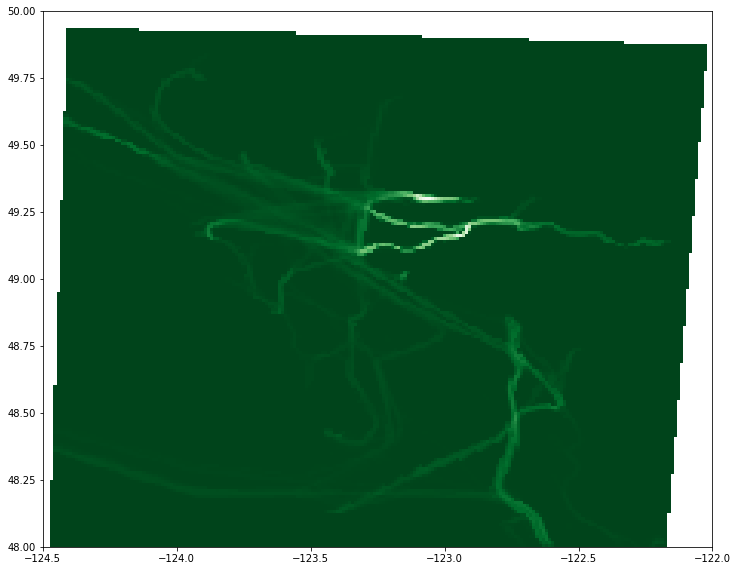

In [6]:
fig, ax = plt.subplots(figsize = (12,12))
show(traffic_reader, ax=ax, cmap = "Greens_r")
ax.set_xlim(-124.5, -122)
ax.set_ylim(48, 50);

In [7]:
(lat,lon, traffic_reader) = get_lat_lon(geotiff_directory, spill_month, 10000)

b'lat-128.66497lon51.02318'


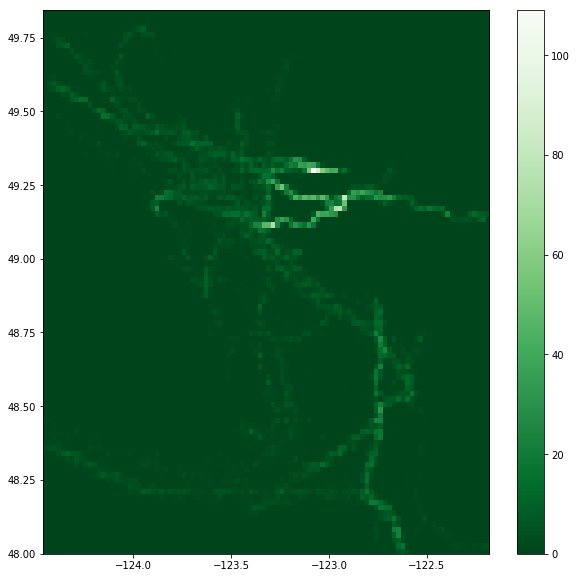

In [8]:
fig, ax = plt.subplots(figsize = (10,10))

h = ax.hist2d(lat, lon, bins=100, cmap = "Greens_r");
plt.colorbar(h[3], ax=ax)

### Investigate downsample
The above results appear downscaled to me and it occured to me that the transform function can operate to either down or upsample the raster image.  Given that our next step was to sub-sample the lat lon, I thought to try to instead to upsamplet the raster to a suitable resolution. 

I do this below in an inelegant but effective way with a subsample variable.

The problem that I ran into is that the latitude and longitude pair array needs to be the same size as the probability array; so I then tried to subsample the geotiff using a method that I read about [here](https://rasterio.readthedocs.io/en/latest/topics/resampling.html).  The result didn't work.  When I searched on the problem, I found that other users have had problems with rosario for down/up sampling

In [9]:
test = np.arange(0,5,.5)

In [10]:
# subsample spacing of 1 km grid (e.g. subsample = 0.1 -> 100 m)
subsample = 0.5

# identify string to use for input file name
if spill_month==9:
    month_name = 'September' #I'm sure there is a way to do this using Datetime!
    
# load data
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0

# calculate probability of traffic by VTE in given month
probability_distribution  = traffic_data/traffic_data.sum()
[nx,ny] = probability_distribution.shape

# create a matrix of lat/lon values 
y_list = np.arange(0,ny,subsample)
x_list = np.arange(0,nx,subsample)
latlontxt = np.chararray((len(x_list),len(y_list)), itemsize = 25)
x_ind = 0
y_ind = 0
for y in range(len(y_list)):
    x_ind = 0
    for x in range(len(x_list)):
        x2, y2 = traffic_reader.transform * (y,x)
        latlontxt[x_ind,y_ind] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))
        x_ind += 1
    y_ind += 1


In [11]:
probability_distribution.shape

(270, 589)

In [12]:
latlontxt.shape

(540, 1178)

In [13]:
 # reshape 2D matrix to vector
latlontxt_1D = latlontxt.reshape(-1)

print(latlontxt_1D[0])
    
# use 'choice' function to randomly select lat/lon location based on vessel time exposure probability
z = choice(latlontxt.reshape(-1), n_locations , p=probability_distribution.reshape(-1))



b'lat-128.66497lon51.02318'


ValueError: a and p must have same size

In [ ]:
    # extract lat/lon value(s)
    lats = np.array([])
    lons = np.array([])
    for i in a:
        lats = np.append(lats, float(i[3:11]))
        lons = np.append(lons, float(i[15:]))

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

h = ax.hist2d(lats, lons, bins=100, cmap = "Greens_r");
plt.colorbar(h[3], ax=ax)

In [ ]:
traffic_reader.transform*(0,0)

In [ ]:
len(y_list)

In [ ]:
range(len(y_list))

In [ ]:
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0

# calculate probability of traffic by VTE in given month
probability_distribution  = traffic_data/traffic_data.sum()
[nx,ny] = probability_distribution.shape

In [ ]:
traffic_reader.scales

### In this section, I explore subsampling geotiff to allow for higher resolution lat/lon values

In [14]:
from rasterio.enums import Resampling
upscale_factor = 2
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')

with traffic_reader as dataset:

    # resample data to target shape
    data = dataset.read(1,
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [15]:
# data 
data = np.squeeze(data)

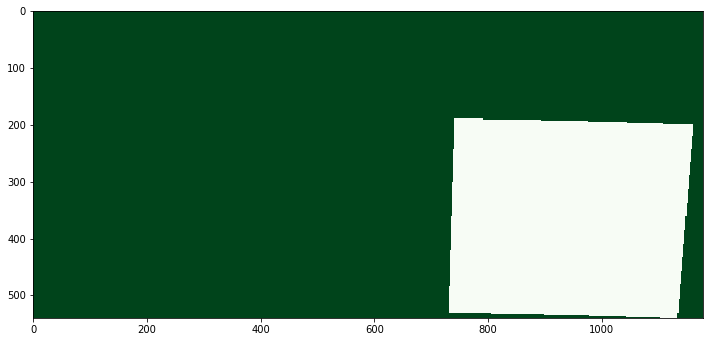

In [21]:
fig, ax = plt.subplots(figsize = (12,12))
h = show(data, ax=ax, cmap = "Greens_r")
#ax.set_xlim(-124.5, -122)
#ax.set_ylim(48, 50);